# Text Classification Problem

We expect a candidate to develop a solution that is capable to classify provided texts in one of **four** classes.
 
You may find the dataset in the **data** folder:
- train.csv contains training dataset. There are four columns in this file:
    - id - column with unique identifier of each data sample
    - category - target variable
    - title - document title
    - description - document text
- test.csv contains test dataset and all the columns are the same except category as it is unknown and should be predicted.
- sample_submission.csv - an example of how resulting submission shoul look like.

Your model should give as an output a probability of each sample belonging to each class.

To submit your solution put this **solution.ipynb** file and generated **submission.csv** in a **zip** file.

We are interested to see how candidate implements his/her typical pipeline to solve machine learning problems starting with a dataset containing both data and target variable.

We **do not** expect a state-of-the-art solution here, rather a code that demonstrates candidate's understanding of crucial parts in ML models development. However, it would be a plus to see a brief description on how to get to the near-state-of-the-art solution in conclusions.

#### Imports

In [1]:
import numpy as np
import pandas as pd 
import re
import random
import string
from collections import defaultdict, Counter
# Importing spacy
import spacy
import en_core_web_sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# To perform EDA on text data
from wordcloud import WordCloud
from textwrap import wrap
# For sentyment analysis
from textblob import TextBlob # Analyze the polarity

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

# Using Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tensorflow.python.keras.callbacks import EarlyStopping

#### Your solution

###### Functions and global parameters

In [2]:
# put your code in this and the following blocks

In [3]:
# Network configuration
max_epochs_process = 50
es = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience=5)

In [4]:
# Loading model
nlp = en_core_web_sm.load()

In [5]:
seed=1
# Stratified KFold structure to evaluate the models
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [6]:
# Function to plot the history for the keras solutions
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [7]:
def confusion_matrix_visualization(conf_matrix, class_names, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp = disp.plot(include_values=True, xticks_rotation='horizontal', ax=None, cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [8]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [9]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [10]:
def check_text_column(data, column, number_of_rows=5):
    start = random.randint(0,len(data)-1)
    for index,text in enumerate(data[column][35:40]):
          print('Review %d:\n'%(index+1),text)

In [11]:
def cleaning_data(data, cols_to_evaluate):
    df = data.copy()
    if isinstance(cols_to_evaluate, str):
        cols_to_evaluate = [cols_to_evaluate]
    for column in cols_to_evaluate:
        # Expanding Contractions in the reviews
        df[f"{column}_clean"]=df[column].apply(lambda x:expand_contractions(x))
        # Lowercase the description column
        df[f"{column}_clean"]=df[f"{column}_clean"].apply(lambda x: x.lower())
        # Remove digits and words containing digits
        df[f"{column}_clean"]=df[f"{column}_clean"].apply(lambda x: re.sub('\w*\d\w*','', x))
        # Remove punctuations
        df[f"{column}_clean"]=df[f"{column}_clean"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        # Removing extra spaces
        df[f"{column}_clean"]=df[f"{column}_clean"].apply(lambda x: re.sub(' +',' ',x))
    return df

In [12]:
# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

In [13]:
def evaluate_performance(y_data, y_pred, model_name):
    accuracy_sc = accuracy_score(y_data, y_pred)
    f1_sc = f1_score(y_data, y_pred,average='weighted')
    recall_sc = recall_score(y_data, y_pred,average='weighted')
    prec_sc = precision_score(y_data, y_pred, average='weighted')
    print(f"\n Metric for model {model_name} are: \n")
    print(f"Accuracy:, {accuracy_sc}")
    print(f"F1 score:, {f1_sc}")
    print(f"Recall:, {recall_sc}")
    print(f"Precision:, {prec_sc}")
    return {'model_name': model_name, 'metrics': [accuracy_sc, f1_sc, recall_sc, prec_sc]}

In [14]:
def keras_model(input_dim, output_dim, X_train, y_train, X_val=None, y_val=None, batch_size=10):
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    if all(item is not None for item in [X_val, y_val]):
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=max_epochs_process,
                      batch_size=batch_size, callbacks=[es], verbose=False)
    else:
        print("Some of the validation data is None. Running process without validation split")
        history = model.fit(X_train, y_train, epochs=max_epochs_process, batch_size=batch_size,
                      callbacks=[es], verbose=False)
    return model, history

In [15]:
# Read the train and test dataset
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [16]:
print(f"Levels of response are {sorted(train_df.loc[:, 'category'].unique())}")
print(f"Columns available are: {train_df.columns}")

# Take a look to see if data is balanced (data is balanced so we won't apply any oversampling or undersampling techniques)
Counter(train_df.loc[:, 'category'])

Levels of response are [0, 1, 2, 3]
Columns available are: Index(['id', 'category', 'title', 'description'], dtype='object')


Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})

In [17]:
# Check the null values in the dataset
print(train_df.isnull().sum()) # Data doesn't have any null values

id             0
category       0
title          0
description    0
dtype: int64


In [18]:
print("Unique description data\n")
print(train_df['description'].unique())
print("\n Unique tittle data\n")
print(train_df['title'].unique())

Unique description data

["Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."
 'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'
 'Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.'
 ...
 "The Miami Dolphins will put their courtship of LSU coach Nick Saban on hold to comply with the NFL's hiring policy by interviewing at least one minority candidate, a team source told The Associated Press last night."
 'PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: Steelers by 10. Records: Steelers 12-1, Giants 5-8. Vs. spread: Steelers 10-1-2, Giants 5-8. Series: Giants lead, 43-27-3. Comments: Think the Giants knew Ben Roethlisberger was available on d

In [19]:
# First, let's visualize some rows of the tittle column and the description column
print(f"Showing some rows of the title column {check_text_column(train_df, 'title', number_of_rows=5)}")
print(f"Showing some rows of the description column {check_text_column(train_df, 'description', number_of_rows=5)}")

Review 1:
 Steady as they go
Review 2:
 Google IPO: Type in 'confusing,' 'secrecy'
Review 3:
 A bargain hunter's paradise
Review 4:
 Researchers seek to untangle the e-mail thread
Review 5:
 Microsoft Corp. 2.0: a kinder corporate culture
Showing some rows of the title column None
Review 1:
 BEDFORD -- Scientists at NitroMed Inc. hope their experimental drugs will cure heart disease someday. But lately their focus has been on more mundane matters.
Review 2:
 I've submitted my bid to buy shares of Google Inc. in the computer search company's giant auction-style initial public offering. That could turn out to be the good news or the bad news.
Review 3:
 Massachusetts bargain hunters showed up in droves and shopped hard on yesterday's sales tax holiday, buying everything from treadmills and snow blowers to candles and chandeliers, and crediting the 5-percent tax break with bringing them into the stores.
Review 4:
 E-mail is a victim of its own success. That's the conclusion of IBM Corp. r

In [20]:
train_df.head(n=10)  # Take a fast look at the dataset

,id,category,title,description
0,0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,5,2,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,6,2,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,7,2,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,8,2,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,9,2,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [21]:
# Data Cleaning
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
# Cleaning data for further analysis. Erase punctuations and spaces in data among others
train_df = cleaning_data(train_df, ['title', 'description'])

In [22]:
train_df.columns  # New generated columns are tittle_clean and description_clean

Index(['id', 'category', 'title', 'description', 'title_clean',
       'description_clean'],
      dtype='object')

In [23]:
# After cleaning the data let's visualize again it's structure
print("Unique clean description \n")
print(train_df['description_clean'].unique())
print("\n Unique clean tittle \n")
print(train_df['title_clean'].unique())

Unique clean description 

['reuters shortsellers wall street is dwindlingband of ultracynics are seeing green again'
 'reuters private investment firm carlyle groupwhich has a reputation for making welltimed and occasionallycontroversial plays in the defense industry has quietly placedits bets on another part of the market'
 'reuters soaring crude prices plus worriesabout the economy and the outlook for earnings are expected tohang over the stock market next week during the depth of thesummer doldrums'
 ...
 'the miami dolphins will put their courtship of lsu coach nick saban on hold to comply with the nfl is hiring policy by interviewing at least one minority candidate a team source told the associated press last night'
 'pittsburgh at ny giants time pm line steelers by records steelers giants vs spread steelers giants series giants lead comments think the giants knew ben roethlisberger was available on draft day when they broke the bank and traded for eli manning all big ben has don

In [24]:
print(f"Showing some rows of the title_clean column {check_text_column(train_df, 'title_clean', number_of_rows=5)}")
print(f"Showing some rows of the description_clean column {check_text_column(train_df, 'title_clean', number_of_rows=5)}")

Review 1:
 steady as they go
Review 2:
 google ipo type in confusing isecrecy
Review 3:
 a bargain hunter is paradise
Review 4:
 researchers seek to untangle the email thread
Review 5:
 microsoft corp a kinder corporate culture
Showing some rows of the title_clean column None
Review 1:
 steady as they go
Review 2:
 google ipo type in confusing isecrecy
Review 3:
 a bargain hunter is paradise
Review 4:
 researchers seek to untangle the email thread
Review 5:
 microsoft corp a kinder corporate culture
Showing some rows of the description_clean column None


In [25]:
# Lemmatization with stopwords removal (may take some time to run so a sample is taken here)
train_df['lemmatized']=train_df['description_clean'].apply(
    lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [26]:
check_text_column(train_df, 'lemmatized', number_of_rows=5)

Review 1:
 bedford scientist nitromed inc hope experimental drug cure heart disease someday lately focus mundane matter
Review 2:
 submit bid buy share google inc computer search company giant auctionstyle initial public offering turn good news bad news
Review 3:
 massachusetts bargain hunter show drove shop hard yesterday sale tax holiday buy treadmill snow blower candle chandelier credit percent tax break bring store
Review 4:
 email victim success conclusion ibm corp researcher cambridge spend nearly decade conduct field test ibm company employee work use electronic mail clear email internet killer application
Review 5:
 genius mess bill gates brilliant technologist cofounde microsoft guide greatness size historical consequence blunder terrorize underling temper parcel praise like scrooge give charity lash inspire necessary aggressiveness beat competition think


In [31]:
train_df_grouped=train_df[['title_clean','lemmatized']].groupby(by='title_clean').agg(lambda x:' '.join(x))
train_df_grouped.head()

,lemmatized
title_clean,
a dream come true says clarke,michael clarke enter australian folklore chinn...
a jaw grown in the shoulder,man lose jawbone cancer enjoy solid meal year ...
a must for xp users washingtonpostcom,washingtonpostcom idea window get mess think h...
a must with xp use,service pack short aim stop virus worm browser...
a wonderful father husband brother and son,confirm family receive absolute proof ken bigl...


In [39]:
# Apply a subset on the rows to overcome memory issues
train_df_subset_grouped = train_df_grouped.sample(frac=0.2)
# Now let's analize the results but first let's create a Document Term Matrix
cv=CountVectorizer()
data=cv.fit_transform(train_df_subset_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=train_df_subset_grouped.index
df_dtm.head(3)

# Transposing document term matrix
df_dtm=df_dtm.transpose()

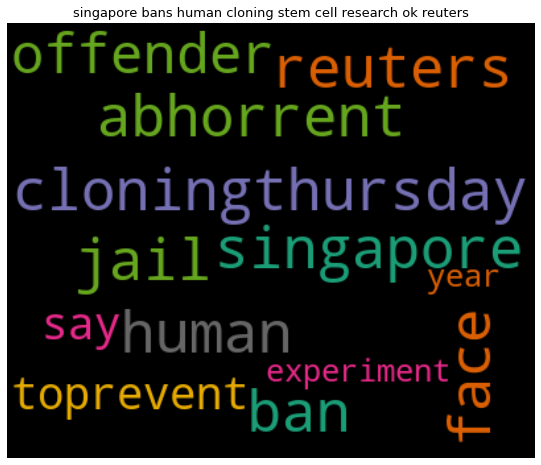

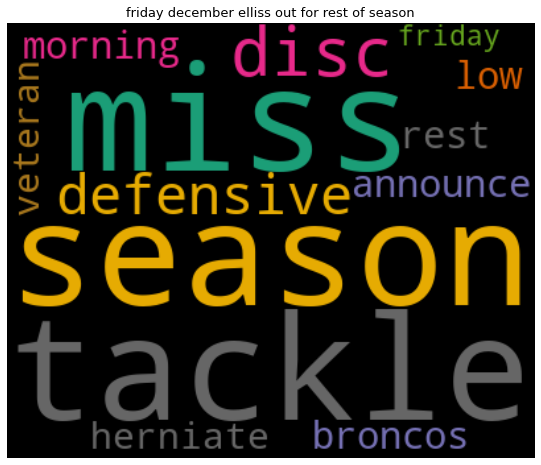

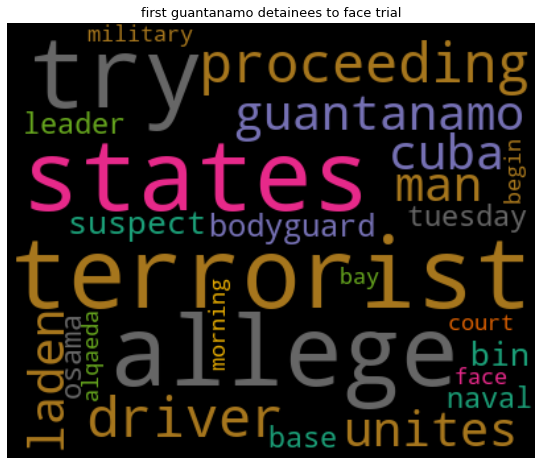

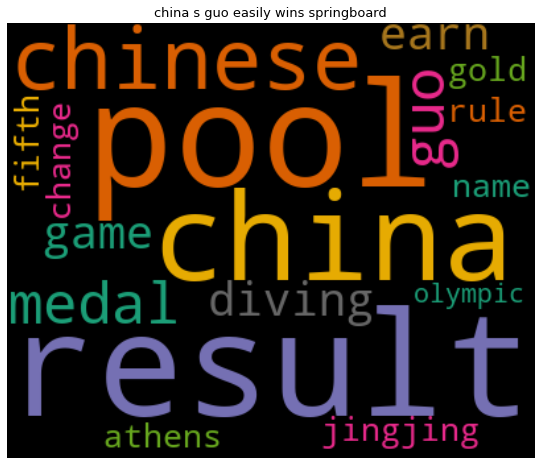

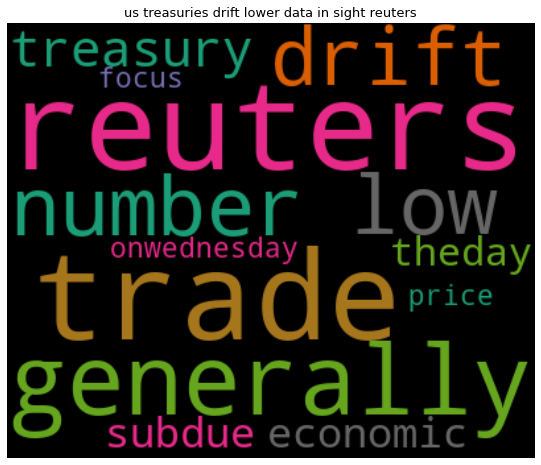

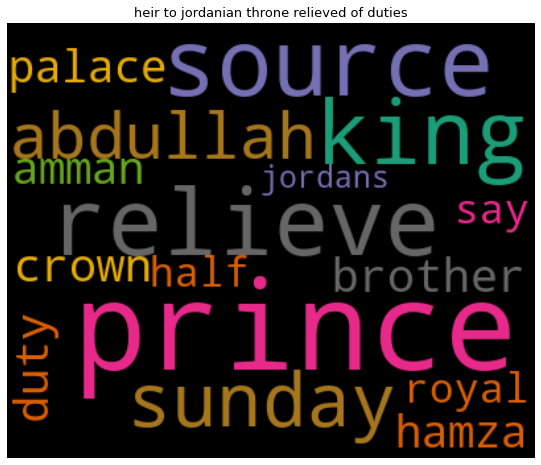

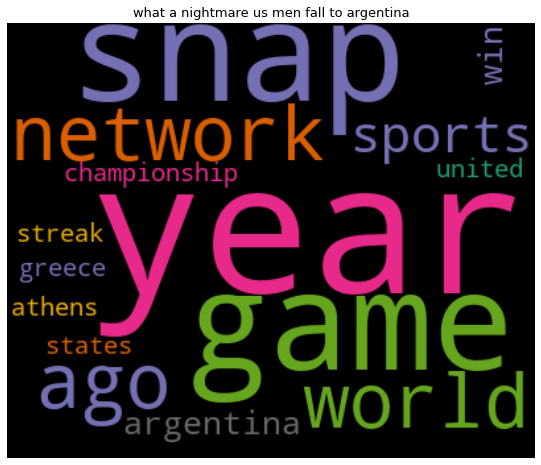

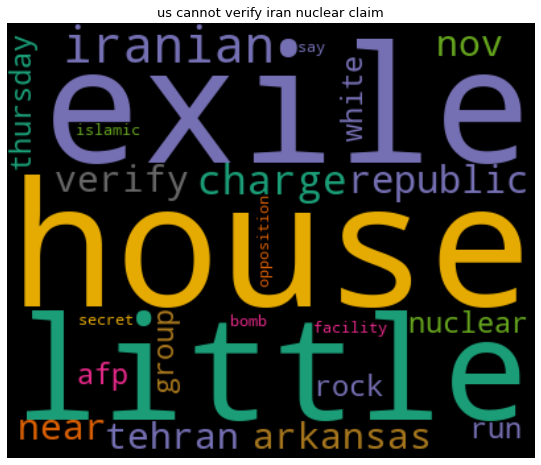

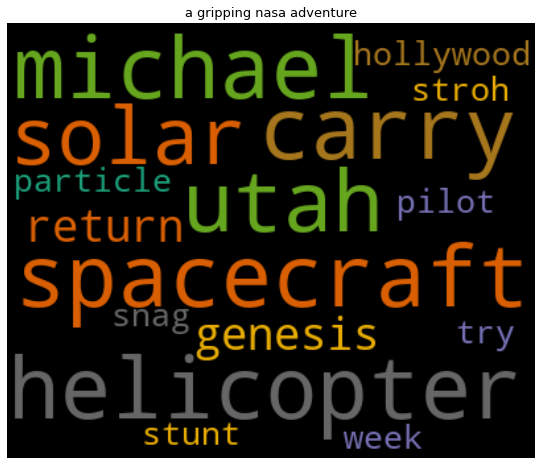

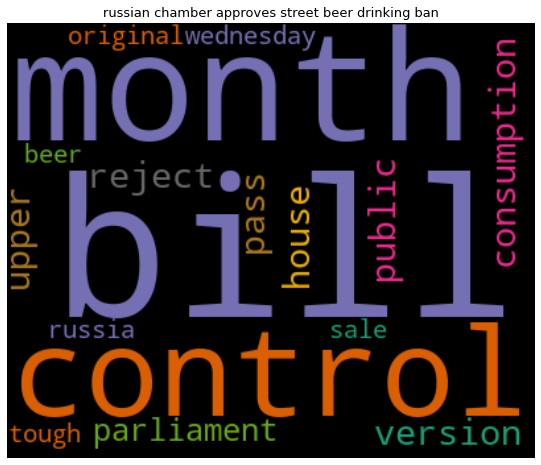

In [40]:
# Let's get the most common words in each new
# Get a random subset of columns (based on the size of the dataset)
index_cols_check = random.sample(range(0, len(df_dtm.columns)-1), 10)
# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns[index_cols_check]):
    generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

In [41]:
# Now let's analyze how good or bad is a new by performing sentyment analysis on the resulting dataset after
# Applying the necessary transfromations on it.
# Check the polarity, i.e., how much a text is positive or negative.
train_df['polarity']=train_df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

print("\n 5 Reviews with Highest Polarity: \n")
for index,review in enumerate(train_df.iloc[train_df['polarity'].sort_values(ascending=False)[:5].index]['description']):
  print('Review {}:\n'.format(index+1),review)

print("\n 5 Reviews with Lowest Polarity: \n")
for index,review in enumerate(train_df.iloc[train_df['polarity'].sort_values(ascending=True)[:5].index]['description']):
  print('Review {}:\n'.format(index+1),review)


 5 Reviews with Highest Polarity: 

Review 1:
 Perfect 10 is suing Google for unspecified damages, alleging copyright infringement. Google provides unauthorized access to thousands of its copyrighted pictures, Perfect 10 says.
Review 2:
 The Tehran Stock Exchange has performed magnificently, but the market's list of risks is outsized.
Review 3:
 AFP - Legendary Indian batsman Sunil Gavaskar has told Sachin Tendulkar not to rest on a world record-equalling 34th Test century, but to target 50 hundreds.
Review 4:
 In a portrait of perfect composition, Saturns moon Tethys has been captured hanging suspended in space just below the planets horizon.
Review 5:
 One legendary coach will replace another at South Carolina next season. According to published reports, former University of Florida and Washington Redskins coach Steve Spurrier will take over the as head 

 5 Reviews with Lowest Polarity: 

Review 1:
 Reuters - Taiwan rescue workers dug out seven\bodies from mud and rock in a mountai

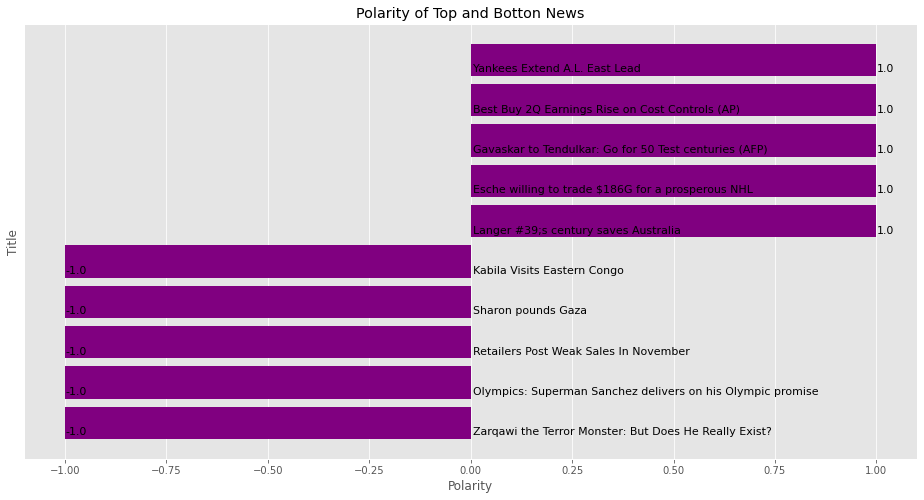

In [42]:
# Finally let's visualize the polarity by using a bar graph but only showing the news with more and less polarity
product_polarity_sorted=pd.DataFrame(train_df.groupby('title')['polarity'].mean().sort_values(ascending=True))

# Get the 5 products with more and less polarity
num_rows = 5
product_polarity_sorted = pd.concat([product_polarity_sorted.head(num_rows), 
                                    product_polarity_sorted.tail(num_rows)], axis=0)

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Top and Botton News')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
    plt.text(0.005,bar.get_y()+0.1,f"{product}",fontsize=11,color='black')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
    plt.text(bar.get_width()+0.001,bar.get_y()+0.1,f"{polarity}",fontsize=11,color='black')
  

plt.yticks([])
plt.show()

Now let's start defining the machine learning approach. Frist, let's create a CountVectorizer to vectorize the sentences taking the words of each sentence and creating a vocabulary of all the unique words in the sentences.
After transforming the data the different models are generated and evaluated to find the best solution to the problem evaluated.

In [43]:
# Now let's start the modelling procedure.
description = train_df.loc[:, "description_clean"].values
y = train_df.loc[:, "category"].values

In [44]:
# Split the data in train and test (we will perform Cross Validation to choose the best model and then 
# evaluate the results on the test data)
X_train, X_test, y_train, y_test = train_test_split(description, y, test_size=0.25, random_state=1000)

In [45]:
# Vectorize the description_clean column
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

# Transform the data
X_train_vec = vectorizer.transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

#### GridSearch approach

In [46]:
# Evaluate some models by using a GridSerach approach
# Grid Serach approach (some models are commented because of execution time)
models = [
            #'GBC',
            'RFC',
            #'KNC',
            'logisticRegression'
         ]
clfs = [
        # GradientBoostingClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed,n_jobs=-1),
        # KNeighborsClassifier(n_jobs=-1),
        LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, max_iter=500)
        ]
params = {
            #models[0]:{'learning_rate':[0.01, 0.1, 0.2],'n_estimators':[10], 'max_depth':[3,5],
            #           'min_samples_split':np.linspace(0.1, 0.5, 3),'min_samples_leaf': np.linspace(0.1, 0.5, 3)},
            models[0]:{'n_estimators':[10, 20, 25], 'criterion':['gini'],'min_samples_split':[2, 10],
                      'min_samples_leaf': [2, 4], 'max_depth': [5, 50]},
            # models[1]:{'n_neighbors':[5,8,10], 'leaf_size':[2,3,5],'weights':['uniform', 'distance']},
            models[1]: {'C':[1,10,100], 'tol': [0.0001]}
         }

In [47]:
dict_scores = defaultdict(dict)
for name, estimator in zip(models,clfs):
    print(name)
    # cv integer, to specify the number of folds in a (Stratified)KFold
    clf = GridSearchCV(estimator, params[name], scoring='balanced_accuracy', refit='True', n_jobs=-1, cv=5)
    clf.fit(X_train_vec, y_train)

    print(f"best params: {str(clf.best_params_)}")
    print(f"best scores: {str(clf.best_score_)}")
    
    dict_scores[name]['parameters'] = clf.best_params_
    dict_scores[name]['score'] = clf.best_score_
    dict_scores[name]['model'] = clf

RFC
best params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}
best scores: 0.8278693010342479
logisticRegression
best params: {'C': 1, 'tol': 0.0001}
best scores: 0.8944732089150363


In [48]:
# Let's select the model having better performance based on the score
tuple_res = max(dict_scores.items(), key=lambda x: x[1]['score'])
best_model_gsearch = {'model_name': tuple_res[0], 'results': tuple_res[1]}
print(f"Best model is {best_model_gsearch['model_name']} and the score obtained is {best_model_gsearch['results']['score']}")

Best model is logisticRegression and the score obtained is 0.8944732089150363


In [49]:
# Draw a confusion matrix on the results
y_pred_gsearch = best_model_gsearch['results']['model'].predict(X_test_vec)

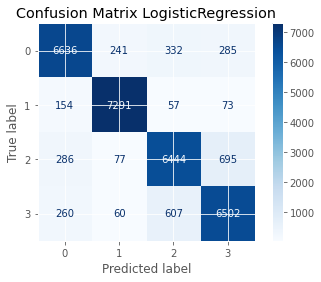

In [50]:
title = "Confusion Matrix LogisticRegression"
class_names = sorted(train_df.loc[:, 'category'].unique())
cm_lr = confusion_matrix(y_test, y_pred_gsearch)
confusion_matrix_visualization(cm_lr, class_names, title)

#### Neural network approach
Now let's compare the results obtained in the GridSearchCV procedure with the results obtained by using a 
neural network.

In [51]:
input_dim = X_train_vec.shape[1]  # Number of features
output_dim = len(train_df.loc[:, 'category'].unique())
print(f"Input dim is {input_dim} and the output dim is {output_dim}")

Input dim is 72509 and the output dim is 4


In [52]:
y_train_keras = to_categorical(y_train) # Pass data to categorical (keras need that step)

seed = 7
cvscores, history_results = [], []
for train, test in kfold.split(X_train_vec, y_train):
    model, history = keras_model(input_dim, output_dim, X_train_vec[train], y_train_keras[train], X_train_vec[test],
                                 y_train_keras[test], batch_size=10)
    history_results.append(history)
    # evaluate the model
    scores = model.evaluate(X_train_vec[test], y_train_keras[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 85.11%
accuracy: 85.18%
Epoch 00043: early stopping
accuracy: 85.80%
Epoch 00043: early stopping
accuracy: 85.78%
accuracy: 86.18%
85.61% (+/- 0.40%)


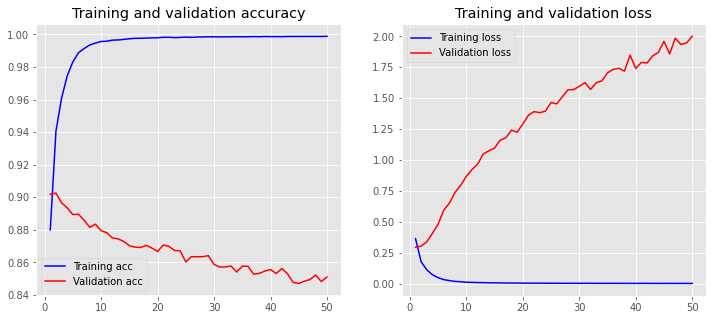

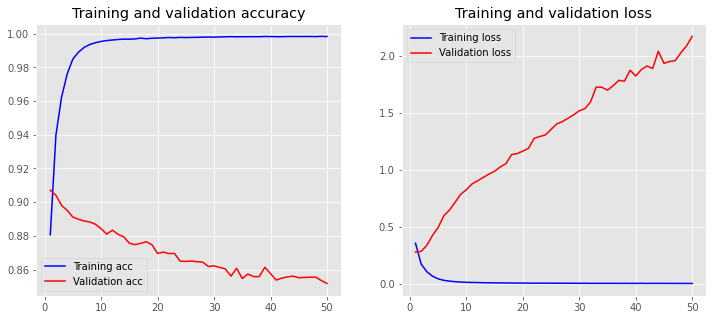

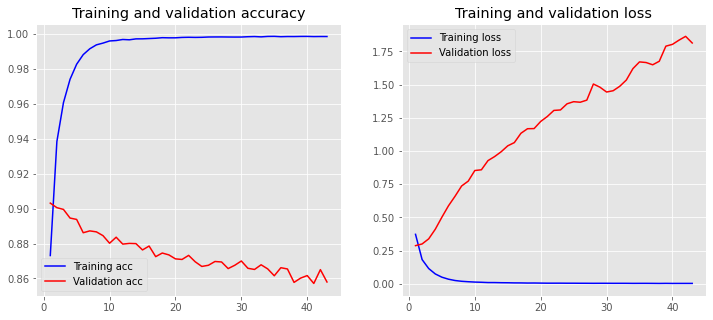

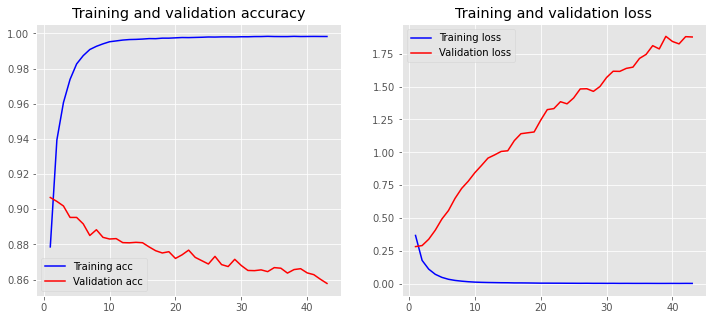

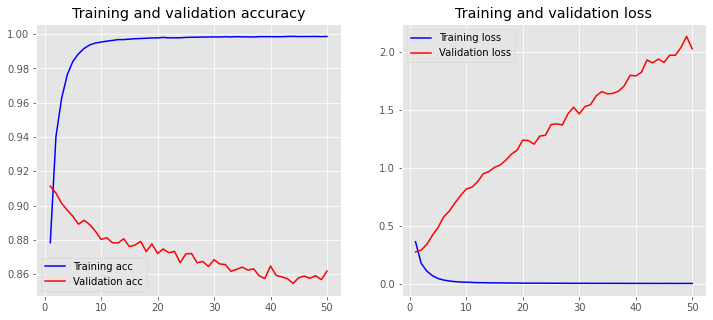

In [53]:
# Let's check how the model performance looks in the Training and Validation data for each generated fold
for history in history_results:
    plot_history(history)

After checking the plots that shows the accuracy and loss on the train and validation data, the performance of the network is quite similar in all the Folds.
Now, let's train the network with all the data reserved as train and let's compare the obtained results with the ones obtained with the GridSearchCV approach.

In [54]:
# Train the final Keras Network with all the data reserved for Train
model_keras, _ = keras_model(input_dim, output_dim, X_train_vec, y_train_keras, batch_size=10)

Some of the validation data is None. Running process without validation split


In [55]:
# Now let's check the accuracy on the reserved test data
y_test_keras = to_categorical(y_test) # pass test data to categorical
loss, accuracy = model_keras.evaluate(X_test_vec, y_test_keras, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

y_pred_kears = model_keras.predict(X_test_vec)
confusion_matrix(y_test, y_pred_kears.argmax(axis=-1))

Testing Accuracy:  0.8658


array([[6392,  266,  498,  338],
       [ 239, 7100,  141,   95],
       [ 375,  109, 6294,  724],
       [ 309,  105,  826, 6189]])

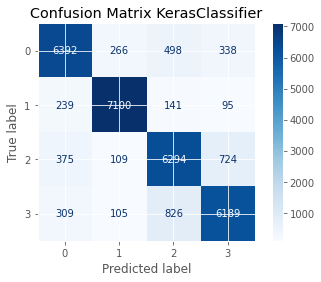

In [56]:
# Finally let's show a visualization of the obtained results by plotting the confusion matrix
title = "Confusion Matrix KerasClassifier"
class_names = sorted(train_df.loc[:, 'category'].unique())
cm_keras = confusion_matrix(y_test, y_pred_kears.argmax(axis=-1))

confusion_matrix_visualization(cm_keras, class_names, title)

Now, let's choose the best model comparing the result of the GridSearchCV approach and the Keras approach. As the problem is a classification problem, let's use a set of metrics to choose our best model

In [57]:
performance_list = list()
model_results = list(map(lambda x, y, z: {'model_name':x, 'pred': y, 'model': z}, 
                         ['KerasClassifier', best_model_gsearch['model_name']], 
                         [y_pred_kears.argmax(axis=-1), y_pred_gsearch],
                         [model_keras, best_model_gsearch['results']['model']]))
for model in model_results:
    performance_model_dict = evaluate_performance(y_test, model['pred'], model_name=model['model_name'])
    performance_model_dict['model'] = model['model']
    performance_list.append(performance_model_dict)


 Metric for model KerasClassifier are: 

Accuracy:, 0.8658333333333333
F1 score:, 0.865956453015898
Recall:, 0.8658333333333333
Precision:, 0.8662727649643173

 Metric for model logisticRegression are: 

Accuracy:, 0.8957666666666667
F1 score:, 0.8956935002145616
Recall:, 0.8957666666666667
Precision:, 0.8957272825846163


In [58]:
best_approach_evaluated = max(performance_list, key=lambda x: x['metrics'])

In [59]:
# Now let's transform the test_df for the column description_clean into a vectorized column
test_df = cleaning_data(test_df, 'description')
X_test_data_vec = vectorizer.transform(test_df.loc[:, "description_clean"].values)

In [60]:
if 'KerasClassifier' in best_approach_evaluated['model_name']:
    print(f"Best model is {best_approach_evaluated['model_name']}")
    results = best_approach_evaluated['model'].predict(X_test_data_vec)
else:
    print(f"Best model is {best_approach_evaluated['model_name']}")
    results = best_approach_evaluated['model'].predict_proba(X_test_data_vec)

Best model is logisticRegression


#### Prepare submission

In [61]:
# edit the following code to generate a submission file
column_names = [f"category_{i}" for i in sorted(train_df.loc[:, 'category'].unique())]
submission = pd.DataFrame(results, columns=column_names).round(2)
submission.insert(loc=0, column='id', value=test_df.loc[:, 'id'])
print(submission.head(n=10)) # Show first 10 values
submission.to_csv('submission.csv', index=False)

   id  category_0  category_1  category_2  category_3
0   0        0.21        0.00        0.77        0.01
1   1        0.00        0.00        0.00        1.00
2   2        0.01        0.01        0.00        0.98
3   3        0.52        0.23        0.00        0.25
4   4        0.25        0.02        0.00        0.73
5   5        0.00        0.00        0.00        1.00
6   6        0.00        0.00        0.00        1.00
7   7        0.00        0.00        0.00        1.00
8   8        0.17        0.03        0.04        0.77
9   9        0.02        0.00        0.05        0.94


# Colnclusions

Write a few words about your solution here. 

What could be improved?

When trying to fit the vectorizer (CountVectorizer) object with the lemmatized column, some memory issues appeared. A different approach should be taken into consideration to be able to use that feature.

In the GridSearch a baseline model (LogisticRegression) is evaluated against the others. It could be interesting to define a simple LogisticRegression without any kind of hyperparameter optimization to use as a baseline model.

Increase the GridSearchCV both in models and parameters tested. Also, instead of perform initially a GridSerach a first step would be a RandomizedSearchCV to reduce the hyperparameter space.

Improve the structure of the code to generate a pipeline that unifies both GridSearch and Keras models.

After cross-validating the Keras model, the batch size should be chosen by testing different values. Also, different network architectures should be tested in order to find the best model.

What approaches may work as well for this problem? 

Apply a Word Embedding like Word2Vec because is one of the most popular representation of document vocabulary.

What would you implement if you have had more time for this task?

Make a further analysis of the results obtained in the exploratory data analysis (EDA) step.

Try to unify the GridSearch and Keras models, use a pipeline to unify all the necessary steps, from data preparation to model selection and validation.

Perform more exploratory data analysis to try to unify the title and the description columns before using them to train the models.

Apply Word Embedding and use Pretrained Word Embeddings. Try Keras Embedding Layer to see if can outperform the results obtained with the Keras model.

Compare the results of the different models on the generated columns for the description variable (description, description_clean and lemmatized).

Finally, generate a configuration file (yaml file) to define the structure of the diferent processes (models) to run, the diferent parameters to evaluate and the features to generate.

Generate a blending of models and apply AutoML techinques.

Feel free to write anything you think is relevant to this task :)

As a final comment say that depending on the approach evaluated, the time of training and validation of the algorithm has divergencies. Analyzing the results, seems that the best approach is obtained by using a LinearRegressor if we combine both time and performance metrics.